In [390]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math

# 1a Logistic "2" Detector

Load data

In [391]:
DATA_FNAME = 'mnist_traindata.hdf5'
DATA2_FNAME = 'mnist_testdata.hdf5'
train_data = h5py.File(DATA_FNAME, 'r+')
test_data = h5py.File(DATA2_FNAME, 'r+')

In [434]:
x_train_data = train_data['xdata'][:] #60_000x784
y_train_data = train_data['ydata'][:] #60_000X10

x_test_data = test_data['xdata'][:] #60_000x784
y_test_data = test_data['ydata'][:] #60_000X10

DETECT_CLASS = 2

target = (y_train_data.argmax(axis = 1) == DETECT_CLASS)
target = 1*target # 6000x1

In [438]:
np.shape((y_train_data))

print(y_train_data[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [393]:
# Initialize Weights to a 784x1 nparray
weights = np.random.normal(0, .05, size=784)
# bias
bias = np.random.normal(0, .05, size=1)

### Functions: Prob, Bin_Cross, Regressor

In [394]:
# Estimate a probability that an input vector x is "2"
"""
For training set, returns a 60000x1 vector with a probability for each input
For testing, returns 10000x1 vector
"""
def prob(x, w, w_0):
    probabilities = np.empty((x.shape[0], 1))
    
    probabilities = 1 / (1 + np.exp(-(np.dot(x, w) + w_0)))
    
    return probabilities

In [395]:
"""
Should return one loss value
For training: 60_000x1
Loss vector should be same size as weight
"""
def bin_cross_loss(x, w, w_0, target):
    
    #target.reshape((len(x), 1))
    p_x = prob(x, w, w_0)
    
    # calculate each element individually and then sum
    #a = target * np.log(p_x)
    #b = (1 - target) * np.log(1 - p_x)
    #c = np.sum(a + b)
    #loss = -(c/len(x))
    
    epsilon = 1e-15  # Small epsilon value to avoid log(0)

    # Calculate the binary cross-entropy loss
    loss = -(np.sum(target * np.log(p_x + epsilon) + (1 - target) * np.log(1 - p_x + epsilon))) / len(x)
    
    # loss = -(np.sum(target * np.log(p_x) + (1 - target) * np.log(1-p_x)))/len(x)
    
    return loss

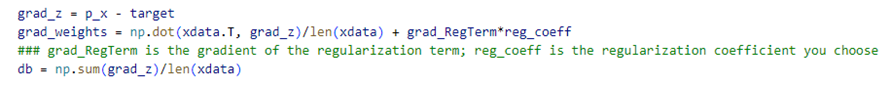

In [396]:
def regressor(w, w_0, x, target, reg_type, reg_coeff, learning_rate):
    p_x = prob(x, w, w_0)
    log_loss = bin_cross_loss(x, w, w_0, target)
    
    gradients_dict = {}
    grad_z = p_x - target
    
    
    if reg_type == 'l1':
        gradients_dict['grad_weights'] = np.dot(x.transpose(), grad_z)/len(x) + ((np.sum(abs(w)))*reg_coeff)/len(x) # pick coeff
    
    else: # if using l2
        gradients_dict['grad_weights'] = np.dot(x.transpose(), grad_z)/len(x) + ((np.linalg.norm(w)**2)*reg_coeff)/len(x)
        # x is 60000x784
        # x.transpose is 784x60000
        # grad_z is 60000x1
        #
    
    #gradients_dict['grad_bias'] = np.sum(grad_z)/len(x)
    gradients_dict['grad_bias'] = -(np.sum((p_x)*(1-p_x)*(1)))/len(x)
    
    new_weights = w - learning_rate * gradients_dict['grad_weights']
    
    new_bias = w_0 - learning_rate * gradients_dict['grad_bias']
    
    return [p_x, log_loss, new_weights, new_bias]

### Testing

In [397]:
p2, loss2, weights2, bias2 = regressor(weights, bias, x_train_data, target, 'l2', .03, .01)
print(loss2)

0.5081222685857401


In [398]:
p3, loss3, weights3, bias3 = regressor(weights2, bias2, x_train_data, target, 'l2', .03, .01)
print(loss3)


0.4850560625155287


In [399]:
p4, loss4, weights4, bias4 = regressor(weights3, bias3, x_train_data, target, 'l2', .01, .01)
print(p4.shape)
print(loss4)
print(weights4.shape)
print(bias4)

(60000,)
0.46551778578681874
(784,)
[0.02217075]


In [400]:
p5, loss5, weights5, bias5 = regressor(weights4, bias4, x_train_data, target, 'l2', .01, .01)
print(loss5)

0.44885565814149475


In [418]:
accuracy = np.sum((p5 >= 0.5) == target) / len(x_train_data)

In [419]:
# rewrite iteratively
def iterative_regressor(w, w_0, x, target, reg_type, reg_coeff, learning_rate, iters):
    # if iters == 0:
    #     return 
    
    # p, loss, weights, bias = regressor(w, w_0, x, target, reg_type, reg_coeff, learning_rate)
    
    # return recursive_regressor(weights, bias, x, target, reg_type, reg_coeff, learning_rate, iters-1)
    
    loss_per_iter = []
    
    p, loss, weights, bias = regressor(w, w_0, x, target, reg_type, reg_coeff, learning_rate)
    iters -= 1
    loss_per_iter.append(loss)
    
    while iters > 0:
        p, loss, weights, bias = regressor(weights, bias, x, target, reg_type, reg_coeff, learning_rate)
        loss_per_iter.append(loss)
        iters -= 1
        
    return p, loss, weights, bias, loss_per_iter

### 3a Questions:
i) I determined my learning rate by starting at .5. I found that the loss ended up spiking back up after a few iterations so I kept lowering it until I saw that the loss consistently decreased from iteration to iteration. I ended up using a value of .01, lowering it from .5 to .1, and then slowly decreasing it further.

ii) I used a certain number of iterations to calculate model convergence, in this case 1000.

iii) I tried both l2 and l1 regularization, and found for some reason l2 worked better. For l1 I was having the same issue where the loss started increasing rapidly after a few iterations.

In [421]:
# iv
# plot training and testing on same map

iterative_on_training = iterative_regressor(weights, bias, x_train_data, target, 'l2', .01, .01, 1000)

target = (y_train_data.argmax(axis = 1) == DETECT_CLASS)
target = 1*target # 6000x1

log_loss_train = iterative_on_training[4]
test_weights = iterative_on_training[2]
test_bias = iterative_on_training[3]

target = (y_test_data.argmax(axis = 1) == DETECT_CLASS)
target = 1*target # 6000x1

iterative_on_testing = iterative_regressor(test_weights, test_bias, x_test_data, target,  'l2', .01, .01, 1000)
log_loss_test = iterative_on_testing[4]

In [441]:
final_weights = iterative_on_testing[2]
final_biases = iterative_on_testing[3]

In [442]:
# saving weights

DATA_FNAME = 'aryan_barik_hw3_p3a.hd5'

with h5py.File(DATA_FNAME, 'w') as hf:
    hf.create_dataset('w', data = np.asarray(final_weights))
    hf.create_dataset('b', data = np.asarray(final_biases))

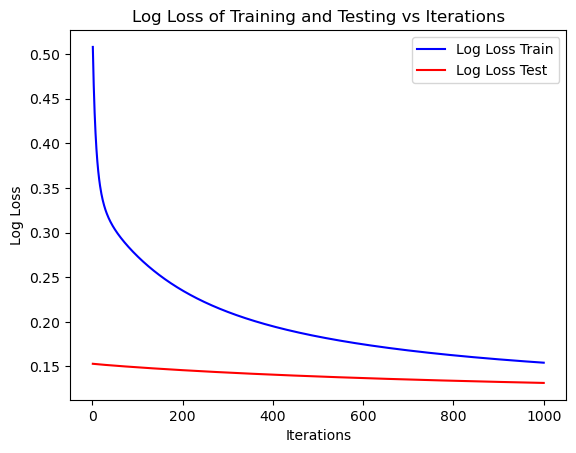

In [422]:
x = [i for i in range(1,1001)]

y1 = log_loss_train
y2 = log_loss_test

plt.plot(x, y1, label='Log Loss Train', color='blue')

# Create the second line plot
plt.plot(x, y2, label='Log Loss Test', color='red')

plt.xlabel('Iterations')
plt.ylabel('Log Loss')

plt.legend()

# Add a title to the plot
plt.title('Log Loss of Training and Testing vs Iterations')

# Show the plot
plt.show()

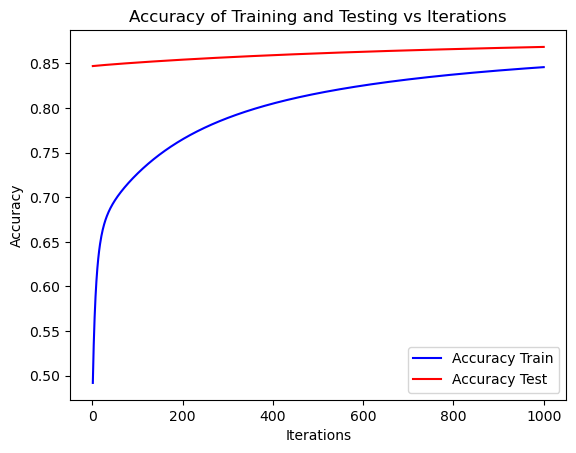

In [426]:
x = [i for i in range(1,1001)]

y1 = 1 - np.array(log_loss_train)
y2 = 1 - np.array(log_loss_test)

plt.plot(x, y1, label='Accuracy Train', color='blue')

# Create the second line plot
plt.plot(x, y2, label='Accuracy Test', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.legend()

# Add a title to the plot
plt.title('Accuracy of Training and Testing vs Iterations')

# Show the plot
plt.show()

![Alt text](image-2.png)

In [439]:
# v
target = (y_train_data.argmax(axis = 1) == DETECT_CLASS)
target = 1*target # 6000x1

# Final Accuracy and Loss Training
train_accuracy = np.sum((iterative_on_training[0] >= 0.5) == target) / len(x_train_data)
train_loss = iterative_on_training[1]


target = (y_test_data.argmax(axis = 1) == DETECT_CLASS)
target = 1*target # 6000x1

# Final Accuracy and Loss Testing
test_accuracy = np.sum((iterative_on_testing[0] >= 0.5) == target) / len(x_test_data)
test_loss = iterative_on_testing[1]

print(train_accuracy, train_loss, test_accuracy, test_loss)

0.9532 0.15423515407884691 0.9607 0.1315741525689427


### 3b Softmax Classification: Gradient Descent

In [369]:
# Initialize Weights to a 784x1 nparray
weights = np.random.normal(0, .05, size=(10, 784))
# bias
bias = np.random.normal(0, .05, size=(10,1))
# augment bc lazy
weights_bias = np.concatenate((weights, bias), axis=1)

#resize to 60000x785 to play nice with the augmented weights and bias
x_train_data = np.hstack((x_train_data, np.ones((60000, 1)) ))
# revert target
#target = y_test_data
target = y_train_data

### Functions: Prob_Softmax, Cross_loss
Remember to split weights and bias before submission

In [370]:
# probability function
# should be 60000x10: weights for each class on eachs ample
def prob_softmax(x, w_b):
    numerator = np.exp(np.dot(x, w_b.transpose()))
    # 60000x784 * 785x10 = # 60000x10
    sum = 0
    
    for w_k in w_b:
        sum += np.exp(np.dot(x, w_k))
        # 60000x784 by 785x1 = 60000x1
    
    
    epsilon = 1e-15  # Small epsilon value
    denominator = sum.reshape((len(x), 1)) + epsilon
    
    # 60000x10 / 60000x1
    return numerator / denominator

In [371]:
def highest_prob(probabilities):
    highest_prob = np.argmax(probabilities, 1)
    
    return highest_prob

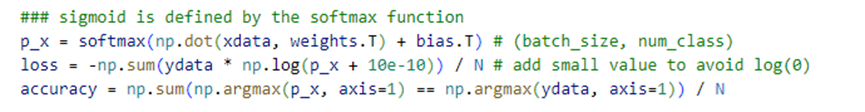

In [372]:
def cross_loss(x, y, probabilities):
    return -np.sum(y * np.log(probabilities + 10e-10)) / len(x)

In [373]:
def softmax_regressor(weights_bias, x, y, target, reg_type, reg_coeff, learning_rate):
    p_x = prob_softmax(x, weights_bias)
    cross_loss_val = cross_loss(x, y, p_x)
    
    gradients_dict = {}
    grad_z = p_x - target
    
    
    if reg_type == 'l1':
        gradients_dict['grad_weights'] = np.dot(x.transpose(), grad_z)/len(x) + (np.sum(abs(weights_bias)))*reg_coeff # pick coeff
    
    else:
        gradients_dict['grad_weights'] = np.dot(x.transpose(), grad_z)/len(x) + (np.linalg.norm(weights_bias)**2)*reg_coeff
    
    gradients_dict['grad_bias'] = -(np.sum((p_x)*(1-p_x)*(1)))/len(x)
    
    new_weights_bias = weights_bias - learning_rate * gradients_dict['grad_weights'].transpose()
    
    
    return [p_x, cross_loss_val, new_weights_bias]

In [386]:
stuff = softmax_regressor(weights_bias, x_train_data, y_train_data, target, 'l2', .001, .1)
print(stuff[1])

2.4640020554142206


In [387]:
stuff2 = softmax_regressor(stuff[2], x_train_data, y_train_data, target, 'l2', .001, .1)
print(stuff2[1])

2.3047427734205286


In [388]:
stuff3 = softmax_regressor(stuff2[2], x_train_data, y_train_data, target, 'l2', .001, .1)
print(stuff3[1])

2.184768634467769


In [389]:
stuff4 = softmax_regressor(stuff3[2], x_train_data, y_train_data, target, 'l2', .001, .1)
print(stuff4[1])

2.083966474333378


![Alt text](image.png)

In [ ]:
MAX_EPOCHS = 10

batch_plot = len(x_train_data) if batch_size == len(x_train_data) else 5000
for epoch in range(MAX_EPOCHS):
    for idx in range(0, len(x_train_data), batch_size):
        batch_end_idx = min(idx + batch_size, len(xdata))
        x, y = x_train_data[idx:batch_end_idx], y_train_data[idx:batch_end_idx]
        accuracy, loss, gradients_dict = regressor(weights, bias, x, y, reg_type=, reg_coeff=)